In [238]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor, GradientBoostingRegressor
from tqdm import tqdm
import numpy as np
import joblib
import seaborn as sns
import os
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
import seaborn as sns
import optuna.visualization.matplotlib as optuna_vis
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
import json

In [13]:
df = pd.read_csv('data_level_2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       671 non-null    object 
 1   month_start                        671 non-null    int64  
 2   year_start                         671 non-null    int64  
 3   month_end                          671 non-null    int64  
 4   year_end                           671 non-null    int64  
 5   total_posts_pr                     671 non-null    int64  
 6   total_posts_nonpr                  671 non-null    int64  
 7   unique_music_pr                    671 non-null    int64  
 8   unique_music_nonpr                 671 non-null    int64  
 9   ttSeller                           671 non-null    bool   
 10  commerceUser                       671 non-null    bool   
 11  emoji_count_pr                     671 non-null    int64  

In [242]:
df.describe()

month_start   year_start  month_end     year_end  total_posts_pr  \
count   671.000000   671.000000  671.00000   671.000000      671.000000   
mean      6.146051  2024.092399    6.14307  2024.259314       13.764531   
std       3.658090     0.289805    3.45769     0.438585       15.395909   
min       1.000000  2024.000000    1.00000  2024.000000        0.000000   
25%       3.000000  2024.000000    3.00000  2024.000000        4.000000   
50%       6.000000  2024.000000    6.00000  2024.000000        9.000000   
75%       9.000000  2024.000000    9.00000  2025.000000       19.000000   
max      12.000000  2025.000000   12.00000  2025.000000      127.000000   

       total_posts_nonpr  unique_music_pr  unique_music_nonpr  emoji_count_pr  \
count         671.000000       671.000000          671.000000      671.000000   
mean           39.986587        12.149031           35.403875        8.606557   
std            22.997627        14.788110           19.513621       13.875896   
min             1.000000         0.000000            1.000000        0.000000   
25%            24.000000         4.000000           21.000000        1.000000   
50%            37.000000         7.000000           32.000000        4.000000   
75%            53.000000        15.000000           47.000000       11.000000   
max           127.000000       127.000000          115.000000      133.000000   

       emoji_count_nonpr  hashtag_count_pr  hashtag_count_nonpr  \
count         671.000000        671.000000           671.000000   
mean           30.505216         64.157973           144.616990   
std            29.854816        107.105341           170.254027   
min             0.000000          0.000000             0.000000   
25%             9.000000         12.000000            39.000000   
50%            23.000000         33.000000            96.000000   
75%            41.000000         84.000000           185.000000   
max           203.000000       1874.000000          1108.000000   

       word_count_no_emoji_hashtag_pr  word_count_no_emoji_hashtag_nonpr  \
count                      671.000000                         671.000000   
mean                       213.731744                         541.259314   
std                        501.935534                         403.773634   
min                          0.000000                          11.000000   
25%                         48.500000                         274.500000   
50%                        104.000000                         431.000000   
75%                        237.500000                         728.000000   
max                      10877.000000                        2964.000000   

       early_morning_pr  pr_ratio_early_morning  early_morning_nonpr  \
count        671.000000              671.000000           671.000000   
mean           0.070045                0.004083             0.736215   
std            0.277806                0.018643             1.899061   
min            0.000000                0.000000             0.000000   
25%            0.000000                0.000000             0.000000   
50%            0.000000                0.000000             0.000000   
75%            0.000000                0.000000             1.000000   
max            2.000000                0.250000            14.000000   

       morning_pr  pr_ratio_morning  morning_nonpr  afternoon_pr  \
count  671.000000        671.000000     671.000000    671.000000   
mean     2.125186          0.120241       5.655738      3.560358   
std      4.421704          0.199262       6.748961      5.799550   
min      0.000000          0.000000       0.000000      0.000000   
25%      0.000000          0.000000       1.000000      0.000000   
50%      1.000000          0.022989       3.000000      1.000000   
75%      2.000000          0.171573       9.000000      4.500000   
max     31.000000          1.000000      45.000000     59.000000   

       pr_ratio_afternoon  afternoon_nonpr  evenin

In [15]:
df.head()

kol_username  month_start  year_start  month_end  year_end  \
0       hnhu2804           10        2024         12      2024   
1       hnhu2804           11        2024          1      2025   
2       hnhu2804           12        2024          2      2025   
3       hnhu2804            1        2025          3      2025   
4  dramakinglndx            1        2024          3      2024   

   total_posts_pr  total_posts_nonpr  unique_music_pr  unique_music_nonpr  \
0               9                 98                4                  54   
1              16                113                7                  62   
2              15                101                8                  57   
3              13                107                6                  53   
4               1                 11                1                  10   

   ttSeller  ...  isSponsored_nonpr  e_outlier_pr  pr_ratio_e_outlier  \
0     False  ...                  0             1            0.111111   
1     False  ...                  0             1            0.062500   
2     False  ...                  0             2            0.133333   
3     False  ...                  0             2            0.153846   
4     False  ...                  0             0            0.000000   

   e_outlier_nonpr  follower_change_in_input_window  pr_engagement_rate_input  \
0               10                                0                  0.025545   
1               11                                0                  0.022451   
2                5                                0                  0.028046   
3                8                                0                  0.025166   
4                1                             5702                  0.050524   

   pr_post_ratio  female_percent  vietnam_follower  \
0       0.084112            90.0              95.0   
1       0.124031            90.0              95.0   
2       0.129310            90.0              95.0   
3       0.108333            90.0              95.0   
4       0.083333            78.0              90.0   

   EngagementRateOnPRPost_target  
0                       0.027464  
1                       0.027832  
2                       0.004797  
3                       0.021435  
4                       0.021049  

[5 rows x 65 columns]

In [16]:
import numpy
print(numpy.__version__)


2.2.0


In [243]:
df.dtypes

kol_username                          object
month_start                            int64
year_start                             int64
month_end                              int64
year_end                               int64
total_posts_pr                         int64
total_posts_nonpr                      int64
unique_music_pr                        int64
unique_music_nonpr                     int64
ttSeller                                bool
commerceUser                            bool
emoji_count_pr                         int64
emoji_count_nonpr                      int64
hashtag_count_pr                       int64
hashtag_count_nonpr                    int64
word_count_no_emoji_hashtag_pr         int64
word_count_no_emoji_hashtag_nonpr      int64
early_morning_pr                       int64
pr_ratio_early_morning               float64
early_morning_nonpr                    int64
morning_pr                             int64
pr_ratio_morning                     float64
morning_no

# H√†m split train test kh√¥ng b·ªã dataleakage

In [244]:
# H√†m l·∫•y danh s√°ch c√°c th√°ng (d·∫°ng (year, month)) trong target
def get_target_months(row, buffer_months=1, target_duration=1):
    # T√≠nh th√°ng b·∫Øt ƒë·∫ßu target: month_end + buffer
    month = row['month_end'] + buffer_months
    year = row['year_end']

    # ƒêi·ªÅu ch·ªânh n·∫øu th√°ng v∆∞·ª£t qu√° 12
    if month > 12:
        month -= 12
        year += 1

    months = []
    for _ in range(target_duration):
        months.append((year, month))
        month += 1
        if month > 12:
            month = 1
            year += 1
    return set(months)

# H√†m chia train-test ƒë√∫ng theo logic KOL v√† target
def split_train_test(df):
    df = df.copy()

    # T√≠nh target_months cho m·ªói sample
    df['target_months'] = df.apply(get_target_months, axis=1)

    # S·∫Øp x·∫øp ƒë·ªÉ l·∫•y sample cu·ªëi c√πng c·ªßa m·ªói KOL l√†m test
    df = df.sort_values(['kol_username', 'year_start', 'month_start'])
    test_samples = df.groupby('kol_username').tail(1)

    # L∆∞u mapping KOL ‚Üí target_months trong test
    kol_to_test_targets = dict(zip(
        test_samples['kol_username'],
        test_samples['target_months']
    ))

    # H√†m ki·ªÉm tra xem sample c√≥ b·ªã leak kh√¥ng (so v·ªõi ch√≠nh KOL ƒë√≥)
    def is_leaked_sample(row):
        kol = row['kol_username']
        if kol not in kol_to_test_targets:
            return False
        return not row['target_months'].isdisjoint(kol_to_test_targets[kol])

    # ƒê√°nh d·∫•u sample b·ªã leak
    is_leak = df.apply(is_leaked_sample, axis=1)

    # L·ªçc l·∫°i: kh√¥ng l·∫•y sample test, kh√¥ng l·∫•y sample b·ªã leak
    train_samples = df[~is_leak & ~df.index.isin(test_samples.index)]

    # B·ªè c·ªôt ph·ª•
    return train_samples.drop(columns='target_months'), test_samples.drop(columns='target_months')

In [245]:
# Chia d·ªØ li·ªáu
train_full_df, test_df = split_train_test(df)

In [246]:
train_full_df.to_csv('full_train_set_lv2.csv', index=False)
test_df.to_csv('test_set_lv2.csv', index=False)


In [247]:
train_full_df.shape

(597, 65)

In [248]:
test_df.shape

(74, 65)

In [249]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       597 non-null    object 
 1   month_start                        597 non-null    int64  
 2   year_start                         597 non-null    int64  
 3   month_end                          597 non-null    int64  
 4   year_end                           597 non-null    int64  
 5   total_posts_pr                     597 non-null    int64  
 6   total_posts_nonpr                  597 non-null    int64  
 7   unique_music_pr                    597 non-null    int64  
 8   unique_music_nonpr                 597 non-null    int64  
 9   ttSeller                           597 non-null    bool   
 10  commerceUser                       597 non-null    bool   
 11  emoji_count_pr                     597 non-null    int64  
 1

In [250]:
test_df.head(20)

kol_username  month_start  year_start  month_end  year_end  \
529             _inlil            9        2024         11      2024   
621   actress.lanhuong            1        2025          3      2025   
653         alissaho23            7        2024          9      2024   
128      beautytips4.0            1        2025          3      2025   
33           biveve131            1        2025          3      2025   
233         blingbabi_            1        2025          3      2025   
167      bychloenguyen            1        2025          3      2025   
220       bylinhtruong            1        2025          3      2025   
397            chaubui           11        2024          1      2025   
140       chouchinchan            1        2025          3      2025   
22           conkien01            1        2025          3      2025   
634     dangvbeauty179            1        2025          3      2025   
582         dieplamanh            1        2025          3      2025   
670       dieplinhcami            1        2025          3      2025   
9        dramakinglndx            1        2025          3      2025   
197  drkhonghanhnguyen            1        2025          3      2025   
541           eb06thg9            1        2025          3      2025   
210  emma1010_official            1        2025          3      2025   
482      gigigithebabe            1        2025          3      2025   
116         goc.cua.ru            1        2025          3      2025   

     total_posts_pr  total_posts_nonpr  unique_music_pr  unique_music_nonpr  \
529               2                 40                2                  38   
621              21                 46               14                  38   
653               5                 61                5                  60   
128              60                  5               59                   5   
33                0                 11                0                  11   
233               3                 44                3                  39   
167               9                 33                9                  33   
220               1                 20                1                  19   
397               4                 36                4                  36   
140              41                 45               41                  45   
22               25                  8               16                   8   
634              17                 30               15                  20   
582              34                 31               29                  31   
670               2                 51                2                  39   
9                 2                  5                2                   5   
197               1                 29                1                  29   
541               8                 35                8                  35   
210               4                 56                4                  53   
482               4                100                4                  78   
116              21                  5               21                   5   

     ttSeller  commerceUser  emoji_count_pr  emoji_count_nonpr  \
529     False         False               2                 34   
621      True         False              18                 28   
653     False         False               2                 10   
128     False         False              60                  3   
33      False         False               0                  5   
233     False         False               3                 52   
167     False         False              11                 48   
220     False          True               0                  3   
397     False         False               7                 36   
140      True          True              17                 24   
22      False          True               9                  5   
634     False         False               0  

In [251]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       597 non-null    object 
 1   month_start                        597 non-null    int64  
 2   year_start                         597 non-null    int64  
 3   month_end                          597 non-null    int64  
 4   year_end                           597 non-null    int64  
 5   total_posts_pr                     597 non-null    int64  
 6   total_posts_nonpr                  597 non-null    int64  
 7   unique_music_pr                    597 non-null    int64  
 8   unique_music_nonpr                 597 non-null    int64  
 9   ttSeller                           597 non-null    bool   
 10  commerceUser                       597 non-null    bool   
 11  emoji_count_pr                     597 non-null    int64  
 1

In [30]:
earliest_sample_per_kol = train_full_df.groupby('kol_username')[['year_start', 'month_start']].min().reset_index()

# Hi·ªÉn th·ªã k·∫øt qu·∫£
print("Th√¥ng tin th√°ng b·∫Øt ƒë·∫ßu s·ªõm nh·∫•t c·ªßa m·ªói KOL:")
# Hi·ªÉn th·ªã t·∫•t c·∫£ c√°c h√†ng (kh√¥ng gi·ªõi h·∫°n)
pd.set_option('display.max_rows', None)

# Hi·ªÉn th·ªã t·∫•t c·∫£ c√°c c·ªôt (kh√¥ng gi·ªõi h·∫°n)
pd.set_option('display.max_columns', None)

# Hi·ªÉn th·ªã to√†n b·ªô n·ªôi dung c·ªßa √¥, kh√¥ng c·∫Øt ng·∫Øn
pd.set_option('display.max_colwidth', None)

# B√¢y gi·ªù b·∫°n c√≥ th·ªÉ hi·ªÉn th·ªã DataFrame c·ªßa m√¨nh
print(earliest_sample_per_kol)

Th√¥ng tin th√°ng b·∫Øt ƒë·∫ßu s·ªõm nh·∫•t c·ªßa m·ªói KOL:
           kol_username  year_start  month_start
0                _inlil        2024            4
1      actress.lanhuong        2024            1
2            alissaho23        2024            3
3         beautytips4.0        2024            2
4             biveve131        2024            7
5            blingbabi_        2024            1
6         bychloenguyen        2024            1
7          bylinhtruong        2024            1
8               chaubui        2024            1
9          chouchinchan        2024            1
10            conkien01        2024            1
11       dangvbeauty179        2024            1
12           dieplamanh        2024            1
13         dieplinhcami        2024            1
14        dramakinglndx        2024            1
15    drkhonghanhnguyen        2024            2
16             eb06thg9        2024            1
17    emma1010_official        2024            1
18      

# Feature Selection

In [31]:
# ƒê·∫£m b·∫£o c√°c c·ªôt d·∫°ng categorical ƒë∆∞·ª£c chuy·ªÉn sang ƒë√∫ng ki·ªÉu
categorical_features = ['ttSeller', 'commerceUser']  # th√™m c√°c c·ªôt categorical b·∫°n c√≥

for col in categorical_features:
    train_full_df[col] = train_full_df[col].astype("category")

In [32]:
target_col = 'EngagementRateOnPRPost_target'

# Lo·∫°i b·ªè c√°c c·ªôt kh√¥ng d√πng
drop_cols = ['kol_username', target_col]
X = train_full_df.drop(columns=drop_cols)
y = train_full_df[target_col]

# === T·∫°o Dataset LightGBM ===
lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features, free_raw_data=False)

# === Train nhanh m√¥ h√¨nh LightGBM ƒë·ªÉ l·∫•y feature importance ===
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100  # ch·ªâ train nhanh th√¥i ƒë·ªÉ l·∫•y importance
)

## Feature importance ( gain ) of LightGBM model

In [ ]:
# === T√≠nh Feature Importance theo 'gain' ===
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance_gain': model.feature_importance(importance_type='gain')
}).sort_values(by='importance_gain', ascending=False)

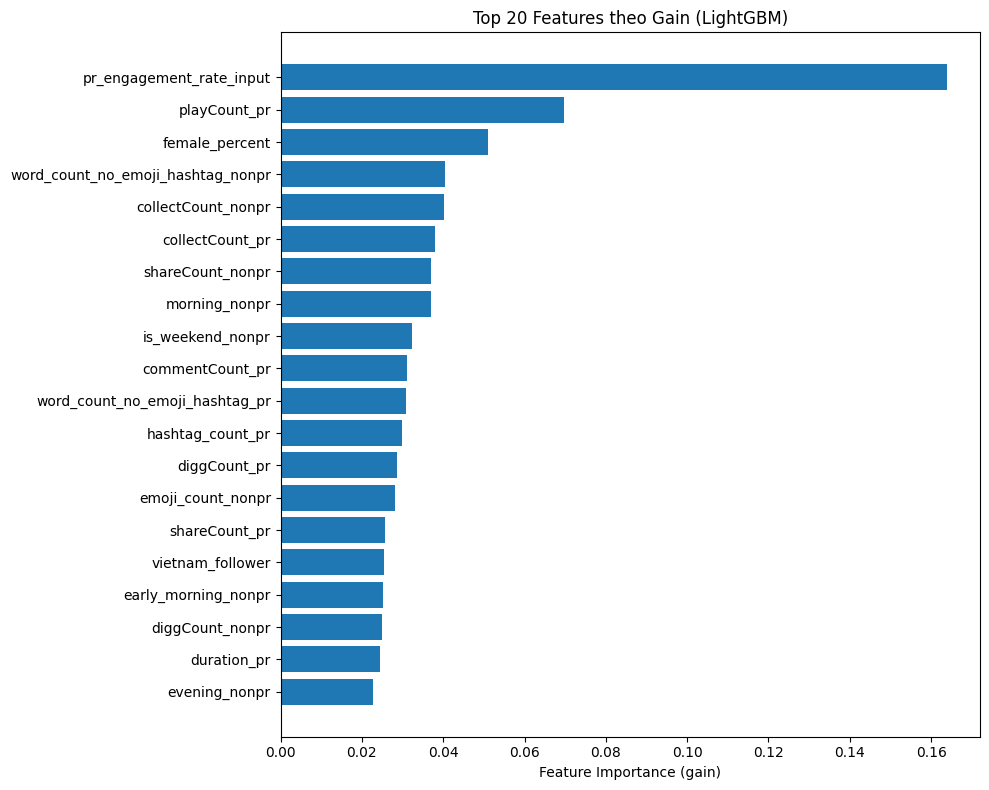

                              feature  importance_gain
59           pr_engagement_rate_input         0.163832
47                       playCount_pr         0.069737
61                     female_percent         0.050905
15  word_count_no_emoji_hashtag_nonpr         0.040537
44                 collectCount_nonpr         0.040301
43                    collectCount_pr         0.038097
42                   shareCount_nonpr         0.037106
21                      morning_nonpr         0.036872
33                   is_weekend_nonpr         0.032379
45                    commentCount_pr         0.031161
14     word_count_no_emoji_hashtag_pr         0.030827
12                   hashtag_count_pr         0.029824
39                       diggCount_pr         0.028655
11                  emoji_count_nonpr         0.028193
41                      shareCount_pr         0.025566
62                   vietnam_follower         0.025486
18                early_morning_nonpr         0.025227
40        

In [34]:
# === Hi·ªÉn th·ªã top 20 feature quan tr·ªçng nh·∫•t ===
plt.figure(figsize=(10, 8))
top_n = 20
plt.barh(importance_df['feature'][:top_n][::-1], importance_df['importance_gain'][:top_n][::-1])
plt.xlabel("Feature Importance (gain)")
plt.title("Top 20 Features theo Gain (LightGBM)")
plt.tight_layout()
plt.show()

# in b·∫£ng
print(importance_df.head(30))

## Shap

In [35]:
# Gi·∫£ s·ª≠ model l√† m√¥ h√¨nh LightGBM ƒë√£ hu·∫•n luy·ªán
explainer = shap.TreeExplainer(model)

# T√≠nh SHAP values cho t·∫≠p train (ho·∫∑c validation)
shap_values = explainer.shap_values(X)

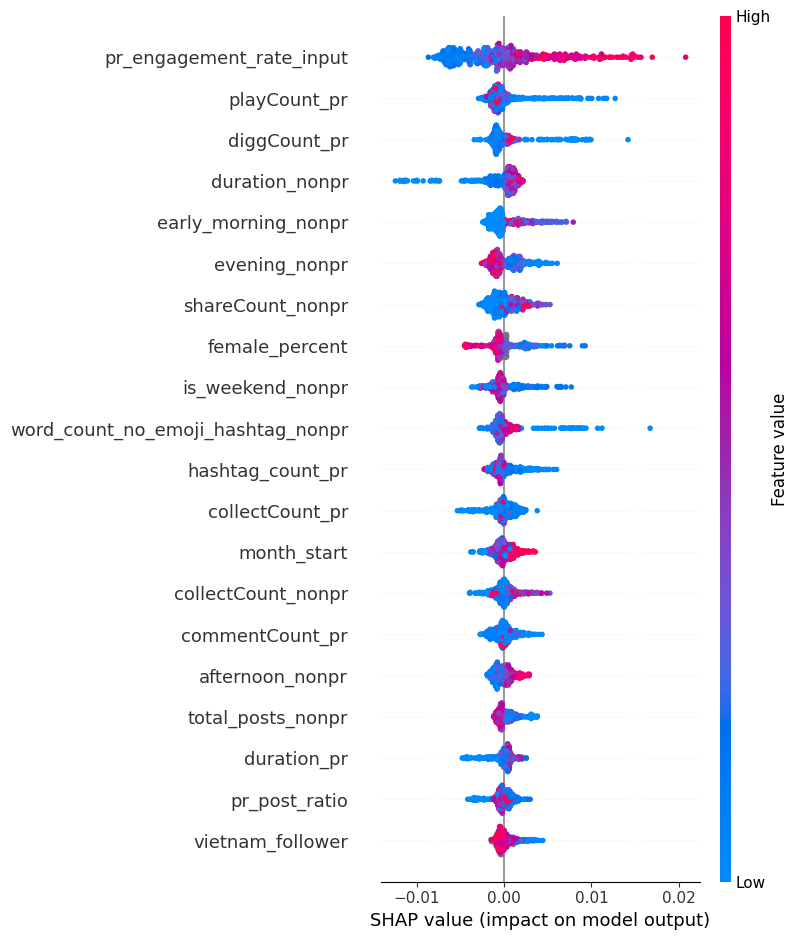

In [36]:
shap.summary_plot(shap_values, X)

## Permutation Importance

In [37]:
# G√°n l·∫°i X v√† y ƒë·ªÉ gi·ªØ nguy√™n c·ªôt 'kol_username' (ƒë√£ b·ªã drop trong b∆∞·ªõc tr∆∞·ªõc)
X_full = train_full_df.drop(columns=[target_col])
y = train_full_df[target_col]

# D·ªØ li·ªáu m√¥ h√¨nh kh√¥ng c√≥ kol_username
X_model = X_full.drop(columns=['kol_username'])

# === T√≠nh baseline RMSE ===
baseline_preds = model.predict(X_model)
baseline_rmse = np.sqrt(mean_squared_error(y, baseline_preds))

# === T√≠nh Permutation Importance (shuffle gi·ªØa c√°c KOL) ===
perm_results = []
feature_names = X_model.columns.tolist()

for feature in tqdm(feature_names):
    X_shuffled = X_model.copy()

    # Shuffle gi√° tr·ªã c·ªßa feature n√†y gi·ªØa c√°c KOL kh√°c nhau
    shuffled_col = []
    for kol in X_full['kol_username'].unique():
        mask = X_full['kol_username'] != kol  # l·∫•y d·ªØ li·ªáu c·ªßa c√°c KOL kh√°c
        available_vals = X_full.loc[mask, feature].values
        kol_size = (X_full['kol_username'] == kol).sum()
        shuffled_vals = np.random.choice(available_vals, size=kol_size, replace=True)
        shuffled_col.append(shuffled_vals)

    X_shuffled[feature] = np.concatenate(shuffled_col)

    if feature in categorical_features:
        # Kh√¥i ph·ª•c l·∫°i dtype category v√† categories ban ƒë·∫ßu
        X_shuffled[feature] = pd.Categorical(
            X_shuffled[feature],
            categories=X_model[feature].cat.categories
        )

    # D·ª± ƒëo√°n l·∫°i
    y_pred_shuffled = model.predict(X_shuffled)
    rmse_shuffled = np.sqrt(mean_squared_error(y, y_pred_shuffled))
    
    importance = rmse_shuffled - baseline_rmse
    perm_results.append((feature, importance))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 63/63 [00:03<00:00, 18.12it/s]


In [38]:
# Chuy·ªÉn sang DataFrame v√† s·∫Øp x·∫øp
perm_df = pd.DataFrame(perm_results, columns=["feature", "perm_importance"])
perm_df = perm_df.sort_values(by="perm_importance", ascending=False)

# In ra top 30 feature
print(perm_df.head(30))

                              feature  perm_importance
59           pr_engagement_rate_input         0.004864
61                     female_percent         0.001854
39                       diggCount_pr         0.001553
47                       playCount_pr         0.001453
15  word_count_no_emoji_hashtag_nonpr         0.001360
38                     duration_nonpr         0.001339
27                      evening_nonpr         0.001316
33                   is_weekend_nonpr         0.001245
18                early_morning_nonpr         0.001212
42                   shareCount_nonpr         0.001064
12                   hashtag_count_pr         0.001063
2                           month_end         0.000852
43                    collectCount_pr         0.000848
40                    diggCount_nonpr         0.000793
44                 collectCount_nonpr         0.000770
45                    commentCount_pr         0.000762
21                      morning_nonpr         0.000673
60        

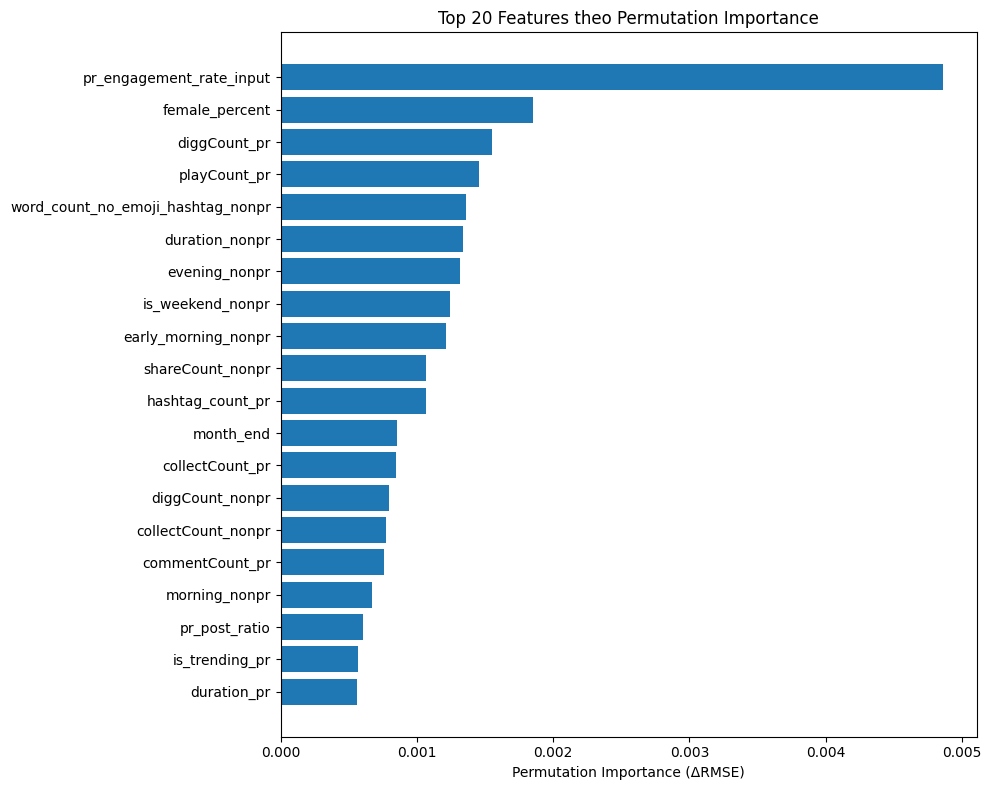

In [39]:
# Ch·ªçn s·ªë l∆∞·ª£ng feature hi·ªÉn th·ªã
top_n = 20
top_features = perm_df.head(top_n)

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"][::-1], top_features["perm_importance"][::-1])
plt.xlabel("Permutation Importance (ŒîRMSE)")
plt.title(f"Top {top_n} Features theo Permutation Importance")
plt.tight_layout()
plt.show()

In [40]:
# 1. === Feature Importance by Gain ===
top_gain = importance_df.sort_values(by='importance_gain', ascending=False).head(15)
gain_features = set(top_gain['feature'])

# 2. === SHAP ===
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)
shap_features = set(shap_df.head(15)['feature'])

# 3. === Permutation Importance ===
top_perm = perm_df.sort_values(by='perm_importance', ascending=False).head(15)
perm_features = set(top_perm['feature'])

# === Union: gi·ªØ t·∫•t c·∫£ c√°c feature xu·∫•t hi·ªán trong √≠t nh·∫•t 1 ph∆∞∆°ng ph√°p
final_features = list(gain_features | shap_features | perm_features)

# In ra k·∫øt qu·∫£
print("‚úÖ Final selected features (xu·∫•t hi·ªán trong √≠t nh·∫•t 1 ph∆∞∆°ng ph√°p):")
print(final_features)

‚úÖ Final selected features (xu·∫•t hi·ªán trong √≠t nh·∫•t 1 ph∆∞∆°ng ph√°p):
['evening_nonpr', 'is_weekend_nonpr', 'month_start', 'female_percent', 'word_count_no_emoji_hashtag_nonpr', 'word_count_no_emoji_hashtag_pr', 'playCount_pr', 'pr_engagement_rate_input', 'collectCount_pr', 'month_end', 'shareCount_nonpr', 'hashtag_count_pr', 'emoji_count_nonpr', 'collectCount_nonpr', 'early_morning_nonpr', 'morning_nonpr', 'duration_nonpr', 'shareCount_pr', 'diggCount_pr', 'diggCount_nonpr', 'commentCount_pr']


In [252]:
final_features

['evening_nonpr',
 'is_weekend_nonpr',
 'month_start',
 'female_percent',
 'word_count_no_emoji_hashtag_nonpr',
 'word_count_no_emoji_hashtag_pr',
 'playCount_pr',
 'pr_engagement_rate_input',
 'collectCount_pr',
 'month_end',
 'shareCount_nonpr',
 'hashtag_count_pr',
 'emoji_count_nonpr',
 'collectCount_nonpr',
 'early_morning_nonpr',
 'morning_nonpr',
 'duration_nonpr',
 'shareCount_pr',
 'diggCount_pr',
 'diggCount_nonpr',
 'commentCount_pr']

In [253]:
len(final_features)

21

---
# Training models

ƒë√°nh gi√° tr√™n c√°c models sau ƒë√¢y:

- Mean Predictor

- Linear Model: Linear Regression, Ridge Regression, Lasso Regression, Support Vector Regression.

- Tree-based Model: RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, XGBoost, LightGBM, CatBoost.


In [254]:
len(list(train_full_df.columns))

65

In [ ]:
train_local_df, dev_df = split_train_test(train_full_df)
# X√°c ƒë·ªãnh c√°c c·ªôt c·∫ßn gi·ªØ l·∫°i
cols_to_keep = final_features + ['EngagementRateOnPRPost_target']

if 'kol_username' in train_full_df.columns:
    cols_to_keep.append('kol_username')

# G√°n l·∫°i ƒë·ªÉ thay ƒë·ªïi tr·ª±c ti·∫øp
train_full_df = train_full_df[cols_to_keep].copy()
train_local_df = train_local_df[cols_to_keep].copy()
dev_df = dev_df[cols_to_keep].copy()
test_df = test_df[cols_to_keep].copy()

In [45]:
train_local_df.to_csv('sub_train_set_lv2.csv', index=False)
dev_df.to_csv('dev_set_lv2.csv', index=False)

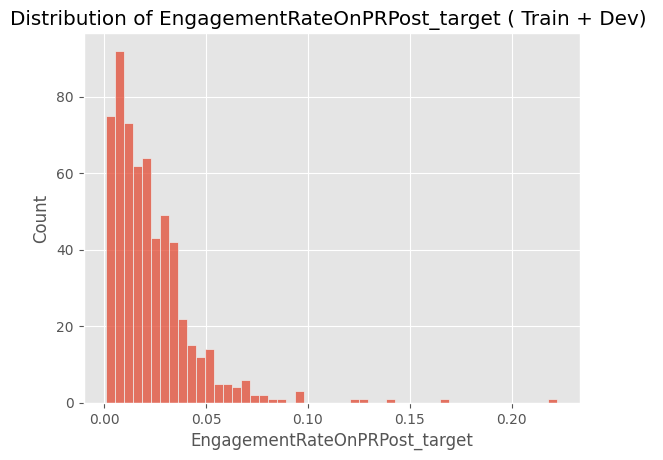

In [124]:
sns.histplot(train_full_df['EngagementRateOnPRPost_target'], bins=50)
plt.title("Distribution of EngagementRateOnPRPost_target ( Train + Dev) ")
plt.show()

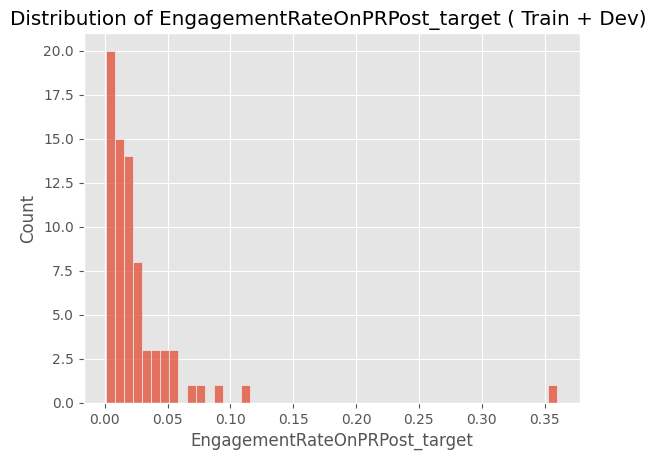

In [232]:
sns.histplot(test_df['EngagementRateOnPRPost_target'], bins=50)
plt.title("Distribution of EngagementRateOnPRPost_target ( Train + Dev) ")
plt.show()

In [256]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      597 non-null    int64  
 1   is_weekend_nonpr                   597 non-null    int64  
 2   month_start                        597 non-null    int64  
 3   female_percent                     415 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  597 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     597 non-null    int64  
 6   playCount_pr                       597 non-null    int64  
 7   pr_engagement_rate_input           597 non-null    float64
 8   collectCount_pr                    597 non-null    int64  
 9   month_end                          597 non-null    int64  
 10  shareCount_nonpr                   597 non-null    int64  
 11  hashtag_count_pr                   597 non-null    int64  
 1

In [257]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      597 non-null    int64  
 1   is_weekend_nonpr                   597 non-null    int64  
 2   month_start                        597 non-null    int64  
 3   female_percent                     415 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  597 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     597 non-null    int64  
 6   playCount_pr                       597 non-null    int64  
 7   pr_engagement_rate_input           597 non-null    float64
 8   collectCount_pr                    597 non-null    int64  
 9   month_end                          597 non-null    int64  
 10  shareCount_nonpr                   597 non-null    int64  
 11  hashtag_count_pr                   597 non-null    int64  
 1

---

# Version 2

In [258]:
train_full_df = pd.read_csv('full_train_set_lv2.csv')

cols_to_keep = final_features + ['EngagementRateOnPRPost_target']
if 'kol_username' in train_full_df.columns:
    cols_to_keep.append('kol_username')
    
train_full_df = train_full_df[cols_to_keep].copy()

train_local_df = pd.read_csv('sub_train_set_lv2.csv')

dev_df = pd.read_csv('dev_set_lv2.csv')

test_df = pd.read_csv('test_set_lv2.csv')
test_df = test_df[cols_to_keep].copy()

In [259]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      597 non-null    int64  
 1   is_weekend_nonpr                   597 non-null    int64  
 2   month_start                        597 non-null    int64  
 3   female_percent                     415 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  597 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     597 non-null    int64  
 6   playCount_pr                       597 non-null    int64  
 7   pr_engagement_rate_input           597 non-null    float64
 8   collectCount_pr                    597 non-null    int64  
 9   month_end                          597 non-null    int64  
 10  shareCount_nonpr                   597 non-null    int64  
 11  hashtag_count_pr                   597 non-null    int64  

In [260]:
train_local_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      528 non-null    int64  
 1   is_weekend_nonpr                   528 non-null    int64  
 2   month_start                        528 non-null    int64  
 3   female_percent                     367 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  528 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     528 non-null    int64  
 6   playCount_pr                       528 non-null    int64  
 7   pr_engagement_rate_input           528 non-null    float64
 8   collectCount_pr                    528 non-null    int64  
 9   month_end                          528 non-null    int64  
 10  shareCount_nonpr                   528 non-null    int64  
 11  hashtag_count_pr                   528 non-null    int64  

In [261]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      69 non-null     int64  
 1   is_weekend_nonpr                   69 non-null     int64  
 2   month_start                        69 non-null     int64  
 3   female_percent                     48 non-null     float64
 4   word_count_no_emoji_hashtag_nonpr  69 non-null     int64  
 5   word_count_no_emoji_hashtag_pr     69 non-null     int64  
 6   playCount_pr                       69 non-null     int64  
 7   pr_engagement_rate_input           69 non-null     float64
 8   collectCount_pr                    69 non-null     int64  
 9   month_end                          69 non-null     int64  
 10  shareCount_nonpr                   69 non-null     int64  
 11  hashtag_count_pr                   69 non-null     int64  
 

In [262]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      74 non-null     int64  
 1   is_weekend_nonpr                   74 non-null     int64  
 2   month_start                        74 non-null     int64  
 3   female_percent                     51 non-null     float64
 4   word_count_no_emoji_hashtag_nonpr  74 non-null     int64  
 5   word_count_no_emoji_hashtag_pr     74 non-null     int64  
 6   playCount_pr                       74 non-null     int64  
 7   pr_engagement_rate_input           74 non-null     float64
 8   collectCount_pr                    74 non-null     int64  
 9   month_end                          74 non-null     int64  
 10  shareCount_nonpr                   74 non-null     int64  
 11  hashtag_count_pr                   74 non-null     int64  
 

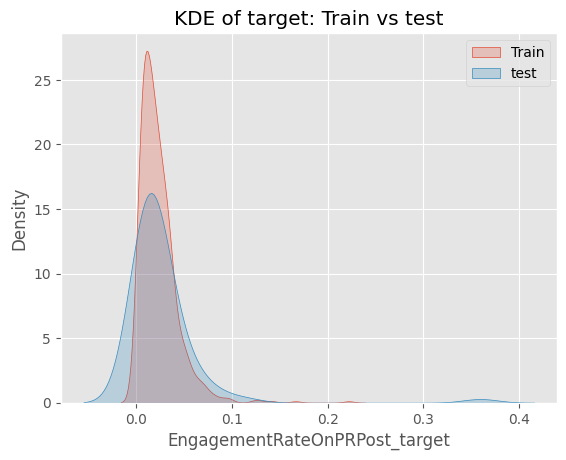

In [147]:
sns.kdeplot(train_full_df["EngagementRateOnPRPost_target"], label="Train", fill=True)
sns.kdeplot(test_df["EngagementRateOnPRPost_target"], label="test", fill=True)
plt.title("KDE of target: Train vs test")
plt.legend()
plt.show()

In [263]:
# ========= D·ªØ li·ªáu =========
drop_columns = ["vietnam_follower", "female_percent", "kol_username"]
X_train = train_local_df[final_features].drop(columns=drop_columns, errors="ignore")
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features].drop(columns=drop_columns, errors="ignore")
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô train_full_df =========
X_full = train_full_df[final_features].drop(columns=drop_columns, errors="ignore")
y_full = train_full_df['EngagementRateOnPRPost_target']

# === D·ªØ li·ªáu test ===
X_test = test_df[final_features].drop(columns=drop_columns, errors="ignore")
y_test = test_df['EngagementRateOnPRPost_target']  # gi·ªØ nguy√™n scale g·ªëc

In [234]:
def evaluate_model(model, X_test, y_test_original):
    y_pred = model.predict(X_test)
    y_test = y_test_original

    # ‚úÖ Th√™m RMSLE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mean_target = y_test.mean()
    
    print('y_test: ',y_test)
    print('y_pred: ',y_pred)

    print("üìä ƒê√°nh gi√° m√¥ h√¨nh:")
    print(f"RMSLE: {rmsle:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R¬≤: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Mean target: {mean_target:.4f}")
    print(f"MAE / mean target: {mae / mean_target:.2%}")
    
    return y_pred


## Mean Predictor

In [181]:
# Gi·∫£ s·ª≠ b·∫°n ƒë√£ c√≥ y_full (log-transform) v√† y_test (scale g·ªëc)

# 1. T√≠nh to√°n gi√° tr·ªã d·ª± ƒëo√°n
mean_target_original_scale = y_full.mean()
y_pred_mean = np.full(y_test.shape[0], mean_target_original_scale)

# 2. T√≠nh to√°n v√† in c√°c ch·ªâ s·ªë
print("================== Mean Predictor ==================")
# RMSLE
rmsle_mean = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_mean)))

# RMSE
rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))

# R¬≤
r2_mean = r2_score(y_test, y_pred_mean)

# MAE
mae_mean = mean_absolute_error(y_test, y_pred_mean)

# Mean target v√† MAE / Mean target
mean_target = y_test.mean()
mae_percentage = mae_mean / mean_target

print("üìä ƒê√°nh gi√° m√¥ h√¨nh Mean Predictor:")
print(f"RMSLE: {rmsle_mean:.4f}")
print(f"RMSE: {rmse_mean:.4f}")
print(f"R¬≤: {r2_mean:.4f}")
print(f"MAE: {mae_mean:.4f}")
print(f"Mean target: {mean_target:.4f}")
print(f"MAE / mean target: {mae_percentage:.2%}")

================== Mean Predictor ==================
üìä ƒê√°nh gi√° m√¥ h√¨nh Mean Predictor:
RMSLE: 0.0387
RMSE: 0.0444
R¬≤: -0.0070
MAE: 0.0196
Mean target: 0.0268
MAE / mean target: 73.14%


## Random Forest

In [182]:
X_train.columns

Index(['evening_nonpr', 'is_weekend_nonpr', 'month_start',
       'word_count_no_emoji_hashtag_nonpr', 'word_count_no_emoji_hashtag_pr',
       'playCount_pr', 'pr_engagement_rate_input', 'collectCount_pr',
       'month_end', 'shareCount_nonpr', 'hashtag_count_pr',
       'emoji_count_nonpr', 'collectCount_nonpr', 'early_morning_nonpr',
       'morning_nonpr', 'duration_nonpr', 'shareCount_pr', 'diggCount_pr',
       'diggCount_nonpr', 'commentCount_pr'],
      dtype='object')

In [183]:
# ========= T·ªëi ∆∞u v·ªõi Optuna =========
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    y_true = y_val 

    # ‚úÖ T√≠nh RMSLE tr√™n scale g·ªëc, b·∫±ng c√°ch log l·∫°i tr∆∞·ªõc khi t√≠nh sai s·ªë
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=100)

# ========= K·∫øt qu·∫£ =========
rf_best_params_v2 = study.best_trial.params
print("‚úÖ Best params:", rf_best_params_v2)

os.makedirs("model_version_2", exist_ok=True)
# ========= L∆∞u c√°c si√™u tham s·ªë t·ªët nh·∫•t v√†o file JSON =========
params_path = "./model_version_2/rf_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(rf_best_params_v2, f, indent=4)
print(f"‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i {params_path}")



rf_model_optuna_v2 = RandomForestRegressor(**rf_best_params_v2, random_state=42)
rf_model_optuna_v2.fit(X_full, y_full)

# ========= L∆∞u l·∫°i =========
model_path = "./model_version_2/rf_model_optuna_v2.pkl"
joblib.dump(rf_model_optuna_v2, model_path)
print(f"‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i {model_path}")

[I 2025-08-22 16:49:56,931] A new study created in memory with name: no-name-ae9b275a-eae8-4381-ac19-393ede1093dd
[I 2025-08-22 16:49:57,818] Trial 0 finished with value: 0.023608723527616157 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.023608723527616157.
[I 2025-08-22 16:49:58,179] Trial 1 finished with value: 0.02333274870097639 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.02333274870097639.
[I 2025-08-22 16:49:58,508] Trial 2 finished with value: 0.023332748700976392 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.02333274870097639.
[I 2025-08-22 16:49:58,962] Trial 3 finished with value: 0.02349817

‚úÖ Best params: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i ./model_version_2/rf_best_params_v2.json
‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i ./model_version_2/rf_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/2680660430.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study)


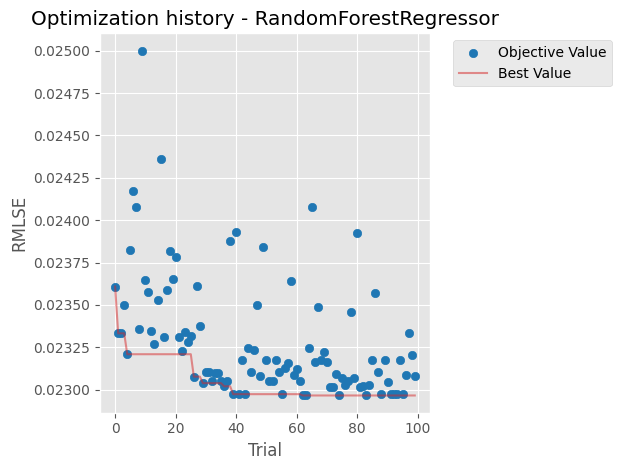

In [184]:
optuna_vis.plot_optimization_history(study)
plt.title("Optimization history - RandomForestRegressor")
plt.xlabel("Trial")
plt.ylabel("RMLSE")
plt.tight_layout()
plt.show()

In [185]:
y_pred_test = evaluate_model(rf_model_optuna_v2, X_test, y_test)

üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0392
RMSE: 0.0449
R¬≤: -0.0291
MAE: 0.0199
Mean target: 0.0268
MAE / mean target: 74.15%


## ExtraTreesRegressor

In [186]:
# ========= T·ªëi ∆∞u v·ªõi Optuna =========
def objective_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    et_model = ExtraTreesRegressor(**params)
    et_model.fit(X_train, y_train)

    # D·ª± ƒëo√°n v√† ƒë·∫£o log
    y_pred = et_model.predict(X_val)
    y_true = y_val

    # ‚úÖ S·ª≠a: T√≠nh RMSLE thay v√¨ RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= T·ªëi ∆∞u Optuna =========
study_et = optuna.create_study(direction='minimize', study_name="ExtraTrees_RMSLE_v2")
study_et.optimize(objective_et, n_trials=100)

# ========= K·∫øt qu·∫£ =========
et_best_params_v2 = study_et.best_trial.params
print("‚úÖ Best params (ExtraTrees v2):", et_best_params_v2)

# ========= L∆∞u c√°c si√™u tham s·ªë t·ªët nh·∫•t v√†o file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/et_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(et_best_params_v2, f, indent=4)
print(f"‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i {params_path}")

# ========= Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô train_full_df =========

et_model_optuna_v2 = ExtraTreesRegressor(**et_best_params_v2, random_state=42)
et_model_optuna_v2.fit(X_full, y_full)

# ========= L∆∞u l·∫°i =========
model_path = "./model_version_2/et_model_optuna_v2.pkl"
joblib.dump(et_model_optuna_v2, model_path)
print(f"‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i {model_path}")

[I 2025-08-22 16:54:10,614] A new study created in memory with name: ExtraTrees_RMSLE_v2
[I 2025-08-22 16:54:11,836] Trial 0 finished with value: 0.0217019224857897 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.0217019224857897.
[I 2025-08-22 16:54:12,711] Trial 1 finished with value: 0.0217601260361967 and parameters: {'n_estimators': 250, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.0217019224857897.
[I 2025-08-22 16:54:13,167] Trial 2 finished with value: 0.021608874094142215 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.021608874094142215.
[I 2025-08-22 16:54:13,461] Trial 3 finished with value: 0.02181518307422277 and parameters: {'n_

‚úÖ Best params (ExtraTrees v2): {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}
‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i ./model_version_2/et_best_params_v2.json
‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i ./model_version_2/et_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/2652969970.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_et)


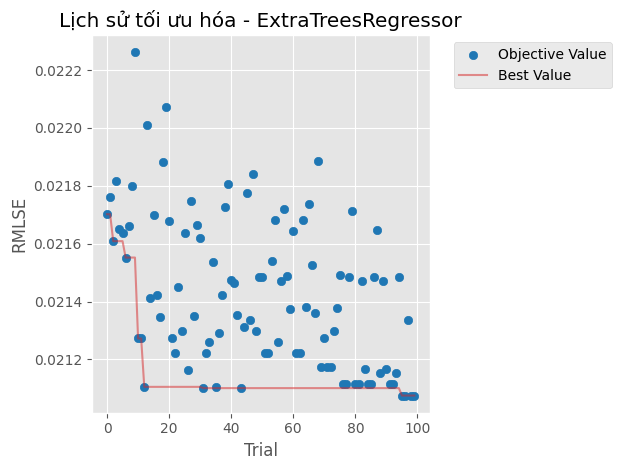

In [187]:
optuna_vis.plot_optimization_history(study_et)
plt.title("L·ªãch s·ª≠ t·ªëi ∆∞u h√≥a - ExtraTreesRegressor")
plt.xlabel("Trial")
plt.ylabel("RMLSE")
plt.tight_layout()
plt.show()

In [233]:
# === D·ªØ li·ªáu test ===
y_pred_test = evaluate_model(et_model_optuna_v2, X_test, y_test)

üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0387
RMSE: 0.0444
R¬≤: -0.0085
MAE: 0.0195
Mean target: 0.0268
MAE / mean target: 72.66%


## HistGradientBoostingRegressor

In [189]:
# ========= T·ªëi ∆∞u v·ªõi Optuna (theo RMSE) =========
def objective_hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'max_iter': trial.suggest_int('max_iter', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 40),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-3, 1.0, log=True),
        'early_stopping': False,
        'random_state': 42
    }

    hgb_model = HistGradientBoostingRegressor(**params)
    hgb_model.fit(X_train, y_train)

    y_pred = hgb_model.predict(X_val)
    y_true = y_val

    # ‚úÖ S·ª≠a: T√≠nh RMSLE thay v√¨ RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= Th·ª±c hi·ªán t·ªëi ∆∞u =========
study_hgb = optuna.create_study(direction='minimize', study_name="HistGradientBoosting_RMLSE")
study_hgb.optimize(objective_hgb, n_trials=100)

# ========= K·∫øt qu·∫£ =========
hgb_best_params_v2 = study_hgb.best_trial.params
print("‚úÖ Best params (HistGradientBoosting, RMLSE):", hgb_best_params_v2)

# ========= L∆∞u c√°c si√™u tham s·ªë t·ªët nh·∫•t v√†o file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/hgb_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(hgb_best_params_v2, f, indent=4)
print(f"‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i {params_path}")

# ========= Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô train_full_df =========

hgb_model_optuna_v2 = HistGradientBoostingRegressor(**hgb_best_params_v2, random_state=42)
hgb_model_optuna_v2.fit(X_full, y_full)

# ========= L∆∞u l·∫°i =========
model_path = "./model_version_2/hgb_model_optuna_v2.pkl"
joblib.dump(hgb_model_optuna_v2, model_path)
print(f"‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i {model_path}")

[I 2025-08-22 17:12:17,876] A new study created in memory with name: HistGradientBoosting_RMLSE
[I 2025-08-22 17:12:19,268] Trial 0 finished with value: 0.026485771309078678 and parameters: {'learning_rate': 0.06771842318323215, 'max_iter': 500, 'max_depth': 4, 'min_samples_leaf': 13, 'l2_regularization': 0.35208966560190724}. Best is trial 0 with value: 0.026485771309078678.
[I 2025-08-22 17:12:19,512] Trial 1 finished with value: 0.023863380101279752 and parameters: {'learning_rate': 0.04234477693881486, 'max_iter': 250, 'max_depth': 3, 'min_samples_leaf': 28, 'l2_regularization': 0.34770255492301827}. Best is trial 1 with value: 0.023863380101279752.
[I 2025-08-22 17:12:19,682] Trial 2 finished with value: 0.02217294975204912 and parameters: {'learning_rate': 0.024024974533926578, 'max_iter': 100, 'max_depth': 9, 'min_samples_leaf': 38, 'l2_regularization': 0.00673737437317987}. Best is trial 2 with value: 0.02217294975204912.
[I 2025-08-22 17:12:19,931] Trial 3 finished with value:

‚úÖ Best params (HistGradientBoosting, RMLSE): {'learning_rate': 0.014769541869488886, 'max_iter': 100, 'max_depth': 9, 'min_samples_leaf': 38, 'l2_regularization': 0.27369319103898665}
‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i ./model_version_2/hgb_best_params_v2.json
‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i ./model_version_2/hgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/3841899641.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_hgb)


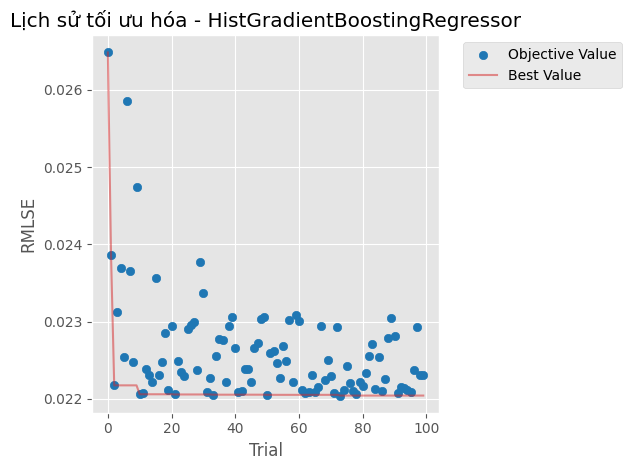

In [190]:
optuna_vis.plot_optimization_history(study_hgb)
plt.title("L·ªãch s·ª≠ t·ªëi ∆∞u h√≥a - HistGradientBoostingRegressor")
plt.xlabel("Trial")
plt.ylabel("RMLSE")
plt.tight_layout()
plt.show()

In [191]:
y_pred_test = evaluate_model(hgb_model_optuna_v2, X_test, y_test)

üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0388
RMSE: 0.0445
R¬≤: -0.0129
MAE: 0.0194
Mean target: 0.0268
MAE / mean target: 72.50%


## XGboost

In [192]:
# ========= T·ªëi ∆∞u v·ªõi Optuna (theo RMSE) =========
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),             
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),           
        'max_depth': trial.suggest_int('max_depth', 3, 10),                             
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'reg:squarederror'
    }

    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_val)
    y_true = y_val

    # ‚úÖ S·ª≠a: T√≠nh RMSLE thay v√¨ RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= Th·ª±c hi·ªán t·ªëi ∆∞u =========
study_xgb = optuna.create_study(direction='minimize', study_name="XGBoost_RMSLE_v2")
study_xgb.optimize(objective_xgb, n_trials=100)

# ========= K·∫øt qu·∫£ =========
xgb_best_params_v2 = study_xgb.best_trial.params
print("‚úÖ Best params (XGBoost, RMSLE):", xgb_best_params_v2)

# ========= L∆∞u c√°c si√™u tham s·ªë t·ªët nh·∫•t v√†o file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/xgb_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(xgb_best_params_v2, f, indent=4)
print(f"‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i {params_path}")

# ========= Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô train_full_df =========

xgb_model_optuna_v2 = xgb.XGBRegressor(**xgb_best_params_v2, random_state=42)
xgb_model_optuna_v2.fit(X_full, y_full)

# ========= L∆∞u l·∫°i =========
model_path = "./model_version_2/xgb_model_optuna_v2.pkl"
joblib.dump(xgb_model_optuna_v2, model_path)
print(f"‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i {model_path}")

[I 2025-08-22 17:15:02,569] A new study created in memory with name: XGBoost_RMSLE_v2
[I 2025-08-22 17:15:03,537] Trial 0 finished with value: 0.022495715590379366 and parameters: {'learning_rate': 0.012185717536397855, 'n_estimators': 450, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8013446304144916, 'colsample_bytree': 0.8356917539773997, 'gamma': 2.8770939874489887, 'reg_alpha': 0.052810459683853846, 'reg_lambda': 0.0012394289550030637}. Best is trial 0 with value: 0.022495715590379366.
[I 2025-08-22 17:15:03,672] Trial 1 finished with value: 0.022491791851774863 and parameters: {'learning_rate': 0.044511518807865476, 'n_estimators': 350, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7280523670326979, 'colsample_bytree': 0.884333677254261, 'gamma': 2.313931076273573, 'reg_alpha': 0.0037204087322891977, 'reg_lambda': 0.0013123026206437567}. Best is trial 1 with value: 0.022491791851774863.
[I 2025-08-22 17:15:04,034] Trial 2 finished with value: 0.0224928768266200

‚úÖ Best params (XGBoost, RMSLE): {'learning_rate': 0.09047219039616851, 'n_estimators': 250, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7253140416589694, 'colsample_bytree': 0.7422196973126346, 'gamma': 2.2596594896398687, 'reg_alpha': 0.001443417631618913, 'reg_lambda': 0.001917202724677949}
‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i ./model_version_2/xgb_best_params_v2.json
‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i ./model_version_2/xgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/3764296788.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_xgb)


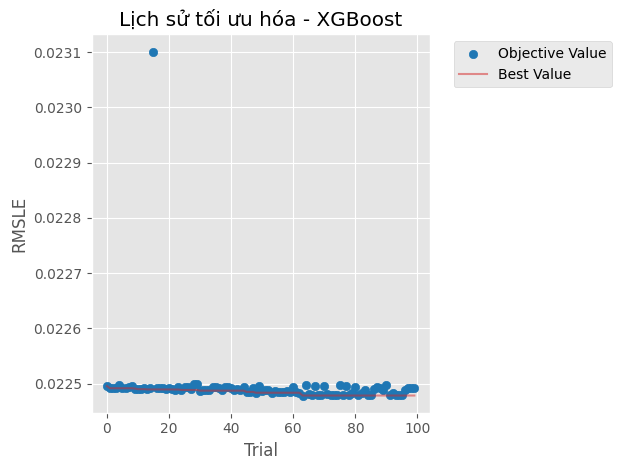

In [193]:
optuna_vis.plot_optimization_history(study_xgb)
plt.title("L·ªãch s·ª≠ t·ªëi ∆∞u h√≥a - XGBoost")
plt.xlabel("Trial")
plt.ylabel("RMSLE")
plt.tight_layout()
plt.show()

In [194]:
# === D·ªØ li·ªáu test ===
y_pred_test = evaluate_model(xgb_model_optuna_v2, X_test, y_test)

üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0387
RMSE: 0.0444
R¬≤: -0.0064
MAE: 0.0196
Mean target: 0.0268
MAE / mean target: 73.34%


## LightGBM

In [195]:
# ========= T·ªëi ∆∞u v·ªõi Optuna (theo RMSE) =========
def objective_lgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train)

    y_pred = lgb_model.predict(X_val)
    y_true = y_val

    # ‚úÖ S·ª≠a: T√≠nh RMSLE thay v√¨ RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle
# ========= T·ªëi ∆∞u h√≥a =========
study_lgb = optuna.create_study(direction='minimize', study_name="LightGBM_RMSLE_v2")
study_lgb.optimize(objective_lgb, n_trials=100)

# ========= K·∫øt qu·∫£ =========
lgb_best_params_v2 = study_lgb.best_trial.params
print("‚úÖ Best params (LightGBM, RMSLE):", lgb_best_params_v2)

# ========= L∆∞u c√°c si√™u tham s·ªë t·ªët nh·∫•t v√†o file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/lgb_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(lgb_best_params_v2, f, indent=4)
print(f"‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i {params_path}")

# ========= Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô train_full_df =========

lgb_model_optuna_v2 = LGBMRegressor(**lgb_best_params_v2, random_state=42)
lgb_model_optuna_v2.fit(X_full, y_full)

# ========= L∆∞u l·∫°i =========
model_path = "./model_version_2/lgb_model_optuna_v2.pkl"
joblib.dump(lgb_model_optuna_v2, model_path)
print(f"‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i {model_path}")

[I 2025-08-22 17:18:00,370] A new study created in memory with name: LightGBM_RMSLE_v2
[I 2025-08-22 17:18:00,823] Trial 0 finished with value: 0.022235611425121773 and parameters: {'learning_rate': 0.055113186856328746, 'n_estimators': 200, 'max_depth': 5, 'num_leaves': 22, 'min_child_samples': 39, 'subsample': 0.9455903910278912, 'colsample_bytree': 0.84122289369994, 'reg_alpha': 0.14714778886427105, 'reg_lambda': 0.01687873846509601}. Best is trial 0 with value: 0.022235611425121773.
[I 2025-08-22 17:18:01,227] Trial 1 finished with value: 0.021945757695749593 and parameters: {'learning_rate': 0.06403450177369378, 'n_estimators': 100, 'max_depth': 7, 'num_leaves': 90, 'min_child_samples': 87, 'subsample': 0.7909708052705335, 'colsample_bytree': 0.7532798399846011, 'reg_alpha': 0.025448970868012562, 'reg_lambda': 0.008008840571541588}. Best is trial 1 with value: 0.021945757695749593.
[I 2025-08-22 17:18:01,490] Trial 2 finished with value: 0.022627498396720954 and parameters: {'lear

‚úÖ Best params (LightGBM, RMSLE): {'learning_rate': 0.016594654378272213, 'n_estimators': 300, 'max_depth': 9, 'num_leaves': 62, 'min_child_samples': 91, 'subsample': 0.8183437071727916, 'colsample_bytree': 0.9409177405729834, 'reg_alpha': 0.010806606418210915, 'reg_lambda': 0.06762120090707914}
‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i ./model_version_2/lgb_best_params_v2.json
‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i ./model_version_2/lgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/4172410820.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_lgb)


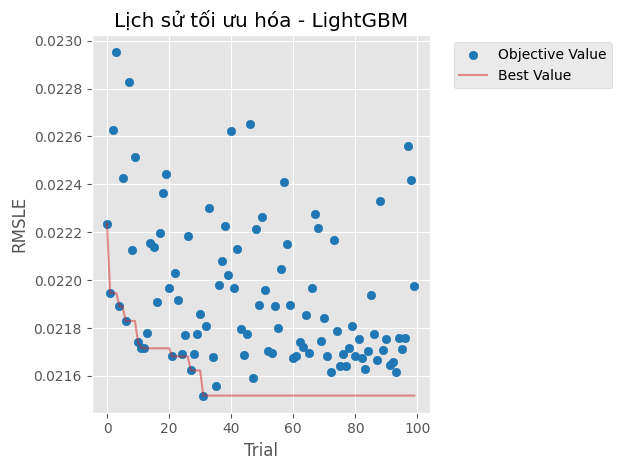

In [196]:
optuna_vis.plot_optimization_history(study_lgb)
plt.title("L·ªãch s·ª≠ t·ªëi ∆∞u h√≥a - LightGBM")
plt.xlabel("Trial")
plt.ylabel("RMSLE")
plt.tight_layout()
plt.show()

In [197]:
# === D·ªØ li·ªáu test ===
y_pred_test = evaluate_model(lgb_model_optuna_v2, X_test, y_test)

üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0392
RMSE: 0.0449
R¬≤: -0.0306
MAE: 0.0199
Mean target: 0.0268
MAE / mean target: 74.31%


## Catboost

In [208]:
# ========= T·ªëi ∆∞u v·ªõi Optuna =========
def objective_cat(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'depth': trial.suggest_int('depth', 3, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'iterations': trial.suggest_int('iterations', 200, 600, step=100),
        'random_strength': trial.suggest_float('random_strength', 0.5, 5.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'loss_function': 'RMSE', # ‚úÖ T·ªëi ∆∞u tr·ª±c ti·∫øp cho RMSLE
        'verbose': 0,
        'random_seed': 42
    }

    cat_model = CatBoostRegressor(**params)
    cat_model.fit(X_train, y_train)

    y_pred = cat_model.predict(X_val)
    y_true = y_val

    # ‚úÖ S·ª≠a: T√≠nh RMSLE thay v√¨ RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= T·ªëi ∆∞u h√≥a =========
study_cat = optuna.create_study(direction='minimize', study_name="CatBoost_RMSLE_v2")
study_cat.optimize(objective_cat, n_trials=100)

# ========= K·∫øt qu·∫£ =========
cat_best_params_v2 = study_cat.best_trial.params
print("‚úÖ Best params (CatBoost, RMSLE):", cat_best_params_v2)

# ========= L∆∞u c√°c si√™u tham s·ªë t·ªët nh·∫•t v√†o file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/cat_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(cat_best_params_v2, f, indent=4)
print(f"‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i {params_path}")

# ========= Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô train_full_df =========

cat_model_optuna_v2 = CatBoostRegressor(**cat_best_params_v2, random_state=42) # ‚úÖ Th√™m random_state
cat_model_optuna_v2.fit(X_full, y_full)

# ========= L∆∞u l·∫°i =========
model_path = "./model_version_2/cat_model_optuna_v2.pkl"
joblib.dump(cat_model_optuna_v2, model_path)
print(f"‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i {model_path}")

[I 2025-08-22 17:26:06,094] A new study created in memory with name: CatBoost_RMSLE_v2
[I 2025-08-22 17:26:06,976] Trial 0 finished with value: 0.023545187412441895 and parameters: {'learning_rate': 0.03808169618609837, 'depth': 8, 'l2_leaf_reg': 4.267400301167388, 'iterations': 400, 'random_strength': 4.055306610949032, 'bagging_temperature': 0.5044323703255277, 'border_count': 43}. Best is trial 0 with value: 0.023545187412441895.
[I 2025-08-22 17:26:07,207] Trial 1 finished with value: 0.022382373116017824 and parameters: {'learning_rate': 0.05436139922266235, 'depth': 3, 'l2_leaf_reg': 9.881287459883838, 'iterations': 500, 'random_strength': 0.545370449224639, 'bagging_temperature': 0.47478466684086795, 'border_count': 33}. Best is trial 1 with value: 0.022382373116017824.
[I 2025-08-22 17:26:07,818] Trial 2 finished with value: 0.022965616639473968 and parameters: {'learning_rate': 0.027862545480040433, 'depth': 8, 'l2_leaf_reg': 4.696436831486443, 'iterations': 200, 'random_stren

‚úÖ Best params (CatBoost, RMSLE): {'learning_rate': 0.013088769497207534, 'depth': 4, 'l2_leaf_reg': 6.922650575329226, 'iterations': 200, 'random_strength': 4.407655582961442, 'bagging_temperature': 0.9493801325752771, 'border_count': 63}
‚úÖ ƒê√£ l∆∞u si√™u tham s·ªë t·∫°i ./model_version_2/cat_best_params_v2.json
0:	learn: 0.0209747	total: 605us	remaining: 120ms
1:	learn: 0.0209533	total: 1.1ms	remaining: 109ms
2:	learn: 0.0209476	total: 1.71ms	remaining: 112ms
3:	learn: 0.0209278	total: 2.25ms	remaining: 110ms
4:	learn: 0.0209045	total: 2.79ms	remaining: 109ms
5:	learn: 0.0208904	total: 3.39ms	remaining: 110ms
6:	learn: 0.0208741	total: 4.25ms	remaining: 117ms
7:	learn: 0.0208671	total: 5.11ms	remaining: 123ms
8:	learn: 0.0208589	total: 5.62ms	remaining: 119ms
9:	learn: 0.0208347	total: 6.21ms	remaining: 118ms
10:	learn: 0.0208099	total: 6.82ms	remaining: 117ms
11:	learn: 0.0207927	total: 7.32ms	remaining: 115ms
12:	learn: 0.0207851	total: 8.15ms	remaining: 117ms
13:	learn: 0.0207

/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/1766385625.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_cat)


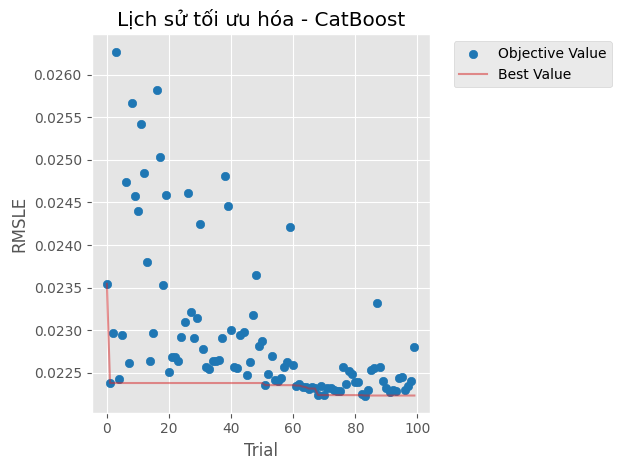

In [209]:
optuna_vis.plot_optimization_history(study_cat)
plt.title("L·ªãch s·ª≠ t·ªëi ∆∞u h√≥a - CatBoost")
plt.xlabel("Trial")
plt.ylabel("RMSLE")
plt.tight_layout()
plt.show()

In [235]:
# === D·ªØ li·ªáu test ===
y_pred_test = evaluate_model(cat_model_optuna_v2, X_test, y_test)

y_test:  0     0.017258
1     0.012579
2     0.024808
3     0.015782
4     0.009111
5     0.004281
6     0.005564
7     0.014736
8     0.015141
9     0.045345
10    0.007617
11    0.113741
12    0.004369
13    0.001405
14    0.359891
15    0.042947
16    0.025158
17    0.020560
18    0.004995
19    0.056007
20    0.004521
21    0.023430
22    0.027428
23    0.073942
24    0.022005
25    0.007220
26    0.021435
27    0.011885
28    0.012821
29    0.012326
30    0.008108
31    0.017860
32    0.003558
33    0.003313
34    0.047850
35    0.008077
36    0.038183
37    0.016217
38    0.001249
39    0.007850
40    0.057283
41    0.058264
42    0.030254
43    0.017851
44    0.015880
45    0.001025
46    0.011373
47    0.011040
48    0.031225
49    0.021550
50    0.022024
51    0.089351
52    0.037679
53    0.044190
54    0.021275
55    0.028812
56    0.026890
57    0.017836
58    0.012363
59    0.008314
60    0.030969
61    0.008534
62    0.070947
63    0.007254
64    0.013454
65    0.009208
6

---

# Linear Model

## ƒêa c·ªông tuy·∫øn

In [266]:
X = X_full.copy()

# ---- T√≠nh VIF ----
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                              Feature        VIF
0                       evening_nonpr   7.405061
1                    is_weekend_nonpr  15.211298
2                         month_start   4.548989
3   word_count_no_emoji_hashtag_nonpr   9.611786
4      word_count_no_emoji_hashtag_pr   6.509409
5                        playCount_pr   9.599703
6            pr_engagement_rate_input   3.267430
7                     collectCount_pr   4.899642
8                           month_end   3.889968
9                    shareCount_nonpr   2.747770
10                   hashtag_count_pr   6.162569
11                  emoji_count_nonpr   5.510528
12                 collectCount_nonpr   5.486680
13                early_morning_nonpr   1.763307
14                      morning_nonpr   3.369482
15                     duration_nonpr   8.615900
16                      shareCount_pr   5.176311
17                       diggCount_pr  18.998489
18                    diggCount_nonpr   5.798171
19                  

In [211]:
def save_model(model, filename, folder="model_version_2"):
    os.makedirs(folder, exist_ok=True)
    model_path = os.path.join(folder, filename)
    joblib.dump(model, model_path)
    print(f"‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i {model_path}")

In [217]:
def evaluate_model_log_target(model, X_test, y_test):
    # D·ª± ƒëo√°n tr√™n thang ƒëo log
    y_pred_log = model.predict(X_test)
    
    # ƒê·∫£o log ƒë·ªÉ so s√°nh v·ªõi y_test ·ªü thang ƒëo g·ªëc
    y_pred = np.expm1(y_pred_log)
    
    # T√≠nh to√°n c√°c ch·ªâ s·ªë
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mean_target = y_test.mean()
    
    print("üìä ƒê√°nh gi√° m√¥ h√¨nh:")
    print(f"RMSLE: {rmsle:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R¬≤: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Mean target: {mean_target:.4f}")
    print(f"MAE / mean target: {mae / mean_target:.2%}")
    
    return y_pred

## Linear Regression

In [212]:
final_features

['evening_nonpr',
 'is_weekend_nonpr',
 'month_start',
 'female_percent',
 'word_count_no_emoji_hashtag_nonpr',
 'word_count_no_emoji_hashtag_pr',
 'playCount_pr',
 'pr_engagement_rate_input',
 'collectCount_pr',
 'month_end',
 'shareCount_nonpr',
 'hashtag_count_pr',
 'emoji_count_nonpr',
 'collectCount_nonpr',
 'early_morning_nonpr',
 'morning_nonpr',
 'duration_nonpr',
 'shareCount_pr',
 'diggCount_pr',
 'diggCount_nonpr',
 'commentCount_pr']

### √°p d·ª•ng log transform

In [226]:
y_train_log = np.log1p(train_local_df['EngagementRateOnPRPost_target'])
y_val_log = np.log1p(dev_df['EngagementRateOnPRPost_target'])
y_full_log = np.log1p(train_full_df['EngagementRateOnPRPost_target'])

In [227]:
X_full.describe()

evening_nonpr  is_weekend_nonpr  month_start  \
count     597.000000        597.000000   597.000000   
mean       18.909548         10.792295     6.629816   
std        12.216113          6.874015     3.426405   
min         0.000000          0.000000     1.000000   
25%        10.000000          6.000000     4.000000   
50%        18.000000         10.000000     7.000000   
75%        26.000000         15.000000    10.000000   
max        66.000000         34.000000    12.000000   

       word_count_no_emoji_hashtag_nonpr  word_count_no_emoji_hashtag_pr  \
count                         597.000000                      597.000000   
mean                          530.110553                      198.169179   
std                           379.089422                      285.657666   
min                            11.000000                        0.000000   
25%                           273.000000                       49.000000   
50%                           426.000000                      109.000000   
75%                           717.000000                      238.000000   
max                          2068.000000                     2295.000000   

       playCount_pr  pr_engagement_rate_input  collectCount_pr   month_end  \
count  5.970000e+02                597.000000       597.000000  597.000000   
mean   1.355787e+07                  0.019355     17354.442211    6.458961   
std    1.966425e+07                  0.014725     36462.891097    3.454460   
min    0.000000e+00                  0.000000         0.000000    1.000000   
25%    2.258600e+06                  0.007969      1618.000000    3.000000   
50%    6.375700e+06                  0.015812      5261.000000    7.000000   
75%    1.667100e+07                  0.027463     16159.000000    9.000000   
max    1.317000e+08                  0.123871    314380.000000   12.000000   

       shareCount_nonpr  hashtag_count_pr  emoji_count_nonpr  \
count        597.000000        597.000000         597.000000   
mean       23006.353434         62.309883          30.385260   
std        36183.040909         81.508077          29.189999   
min            5.000000          0.000000           0.000000   
25%         3359.000000         13.000000           9.000000   
50%        11157.000000         35.000000          23.000000   
75%        27761.000000         84.000000          43.000000   
max       350100.000000        664.000000         203.000000   

       collectCount_nonpr  early_morning_nonpr  morning_nonpr  duration_nonpr  \
count          597.000000           597.000000     597.000000      597.000000   
mean         67260.755444             0.728643       5.567839     2481.591290   
std         100082.304500             1.882470       6.545979     1867.058623   
min             34.000000             0.000000       0.000000       25.000000   
25%          10178.000000             0.000000       1.000000     1228.000000   
50%          31543.000000             0.000000       3.000000     2006.000000   
75%          77627.000000             1.000000       9.000000     3363.000000   
max         940842.000000            14.000000      45.000000    12899.000000   

       shareCount_pr  diggCount_pr  diggCount_nonpr  commentCount_pr  
count     597.000000  5.970000e+02     5.970000e+02       597.000000  
mean     5680.924623  2.433252e+05     1.185540e+06      2888.418760  
std     15378.399153  4.856201e+05     1.880133e+06      7630.453254  
min         0.000000  0.000000e+00     6.360000e+02         0.000000  
25%       449.000000  3.148600e+04     1.730820e+05       232.000000  
50%      1499.000000  8.611700e+04     4.623410e+05       702.000000  
75%      3628.000000  2.029690e+05     1.370573e+06      1725.000000  
max    230156.000000  4.143000e+06     1.341619e+07     69571.000000

In [221]:
# ==== Pipeline: StandardScaler + PCA + Linear Regression ====
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),  # gi·ªØ 95% ph∆∞∆°ng sai
    ("lr", LinearRegression())
])

# ‚úÖ Hu·∫•n luy·ªán tr√™n y_full_log
pipeline_lr.fit(X_full, y_full_log)

print("üîπ Linear Regression")
# ‚úÖ S·ª≠ d·ª•ng h√†m ƒë√°nh gi√° m·ªõi
_ = evaluate_model_log_target(pipeline_lr, X_test, y_test)

üîπ Linear Regression
üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0394
RMSE: 0.0450
R¬≤: -0.0341
MAE: 0.0198
Mean target: 0.0268
MAE / mean target: 73.89%


## Ridge

In [228]:
def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("ridge", Ridge(alpha=alpha, random_state=42))
    ])
    # ‚úÖ Hu·∫•n luy·ªán tr√™n d·ªØ li·ªáu ƒë√£ log-transform
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_val)
    
    # ‚úÖ T√≠nh RMSLE b·∫±ng c√°ch so s√°nh hai gi√° tr·ªã ƒë√£ log-transform
    rmsle = np.sqrt(mean_squared_error(y_val_log, y_pred_log))
    return rmsle

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=100)

best_alpha_ridge = study_ridge.best_params['alpha']
pipeline_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("ridge", Ridge(alpha=best_alpha_ridge, random_state=42))
])
# ‚úÖ Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô d·ªØ li·ªáu ƒë√£ log-transform
pipeline_ridge.fit(X_full, y_full_log)

# ‚úÖ L∆∞u m√¥ h√¨nh
# save_model(pipeline_ridge, "ridge_model_optuna.pkl")

print("üîπ Ridge Regression")
# ‚úÖ S·ª≠ d·ª•ng h√†m ƒë√°nh gi√° ƒë√£ ƒë∆∞·ª£c t·∫°o s·∫µn
_ = evaluate_model_log_target(pipeline_ridge, X_test, y_test)

[I 2025-08-22 18:04:07,281] A new study created in memory with name: no-name-e2c8c9e7-6049-4570-b8f7-cef85c958fd1
[I 2025-08-22 18:04:07,552] Trial 0 finished with value: 0.02173511943500007 and parameters: {'alpha': 0.0018602797151271633}. Best is trial 0 with value: 0.02173511943500007.
[I 2025-08-22 18:04:07,577] Trial 1 finished with value: 0.021734361861726316 and parameters: {'alpha': 0.3110466039452071}. Best is trial 1 with value: 0.021734361861726316.
[I 2025-08-22 18:04:07,595] Trial 2 finished with value: 0.021733410991385156 and parameters: {'alpha': 0.7012551747206922}. Best is trial 2 with value: 0.021733410991385156.
[I 2025-08-22 18:04:07,612] Trial 3 finished with value: 0.021735114468864763 and parameters: {'alpha': 0.003882220707470524}. Best is trial 2 with value: 0.021733410991385156.
[I 2025-08-22 18:04:07,645] Trial 4 finished with value: 0.021733281892672617 and parameters: {'alpha': 0.7544177074307999}. Best is trial 4 with value: 0.021733281892672617.
[I 2025-

üîπ Ridge Regression
üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0393
RMSE: 0.0450
R¬≤: -0.0331
MAE: 0.0198
Mean target: 0.0268
MAE / mean target: 73.81%


## Lasso Regression

In [229]:
# ========= T·ªëi ∆∞u v·ªõi Optuna (tr√™n RMSLE) =========
def objective_lasso(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1.0, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("lasso", Lasso(alpha=alpha, max_iter=10000, random_state=42))
    ])
    # ‚úÖ Hu·∫•n luy·ªán tr√™n d·ªØ li·ªáu ƒë√£ log-transform
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_val)
    
    # ‚úÖ T√≠nh RMSLE b·∫±ng c√°ch so s√°nh hai gi√° tr·ªã ƒë√£ log-transform
    rmsle = np.sqrt(mean_squared_error(y_val_log, y_pred_log))
    return rmsle

study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=100)

best_alpha_lasso = study_lasso.best_params['alpha']
pipeline_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("lasso", Lasso(alpha=best_alpha_lasso, max_iter=10000, random_state=42))
])
# ‚úÖ Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô d·ªØ li·ªáu ƒë√£ log-transform
pipeline_lasso.fit(X_full, y_full_log)

# ‚úÖ L∆∞u m√¥ h√¨nh
save_model(pipeline_lasso, "lasso_model_optuna.pkl")

print("üîπ Lasso Regression")
# ‚úÖ S·ª≠ d·ª•ng h√†m ƒë√°nh gi√° ƒë√£ ƒë∆∞·ª£c t·∫°o s·∫µn
_ = evaluate_model_log_target(pipeline_lasso, X_test, y_test)

[I 2025-08-22 18:11:22,848] A new study created in memory with name: no-name-3c7b835f-d15c-4455-bc7b-4285fd4f172d
[I 2025-08-22 18:11:23,037] Trial 0 finished with value: 0.022505521109762443 and parameters: {'alpha': 0.1735550292115238}. Best is trial 0 with value: 0.022505521109762443.
[I 2025-08-22 18:11:23,054] Trial 1 finished with value: 0.021754315283606985 and parameters: {'alpha': 0.00015154627511432882}. Best is trial 1 with value: 0.021754315283606985.
[I 2025-08-22 18:11:23,067] Trial 2 finished with value: 0.022505521109762443 and parameters: {'alpha': 0.1155094508384959}. Best is trial 1 with value: 0.021754315283606985.
[I 2025-08-22 18:11:23,076] Trial 3 finished with value: 0.022472149833146025 and parameters: {'alpha': 0.005343232358201029}. Best is trial 1 with value: 0.021754315283606985.
[I 2025-08-22 18:11:23,090] Trial 4 finished with value: 0.022505521109762443 and parameters: {'alpha': 0.06264081430620559}. Best is trial 1 with value: 0.021754315283606985.
[I 2

‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i model_version_2/lasso_model_optuna.pkl
üîπ Lasso Regression
üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0393
RMSE: 0.0449
R¬≤: -0.0315
MAE: 0.0197
Mean target: 0.0268
MAE / mean target: 73.58%


## SVR

In [230]:
# ========= T·ªëi ∆∞u v·ªõi Optuna (tr√™n RMSLE) =========
def objective_svr(trial):
    C = trial.suggest_float("C", 0.1, 100.0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-4, 0.1, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("svr", SVR(kernel='rbf', C=C, epsilon=epsilon))
    ])
    # ‚úÖ Hu·∫•n luy·ªán tr√™n d·ªØ li·ªáu ƒë√£ log-transform
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_val)
    
    # ‚úÖ T√≠nh RMSLE b·∫±ng c√°ch so s√°nh hai gi√° tr·ªã ƒë√£ log-transform
    rmsle = np.sqrt(mean_squared_error(y_val_log, y_pred_log))
    return rmsle

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=100)

best_params_svr = study_svr.best_params
pipeline_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("svr", SVR(kernel='rbf', C=best_params_svr["C"], epsilon=best_params_svr["epsilon"]))
])
# ‚úÖ Hu·∫•n luy·ªán l·∫°i tr√™n to√†n b·ªô d·ªØ li·ªáu ƒë√£ log-transform
pipeline_svr.fit(X_full, y_full_log)

# ‚úÖ L∆∞u m√¥ h√¨nh
save_model(pipeline_svr, "svr_model_optuna.pkl")

print("üîπ SVR")
# ‚úÖ S·ª≠ d·ª•ng h√†m ƒë√°nh gi√° ƒë√£ ƒë∆∞·ª£c t·∫°o s·∫µn
_ = evaluate_model_log_target(pipeline_svr, X_test, y_test)

[I 2025-08-22 18:12:31,855] A new study created in memory with name: no-name-29f795a0-31f2-4a68-b180-41d14e97e520
[I 2025-08-22 18:12:32,558] Trial 0 finished with value: 0.028624223577413153 and parameters: {'C': 13.549378475728439, 'epsilon': 0.000413541031609482}. Best is trial 0 with value: 0.028624223577413153.
[I 2025-08-22 18:12:32,569] Trial 1 finished with value: 0.04269413334765738 and parameters: {'C': 1.0835981005554451, 'epsilon': 0.08185657793734255}. Best is trial 0 with value: 0.028624223577413153.
[I 2025-08-22 18:12:32,623] Trial 2 finished with value: 0.019698862278973515 and parameters: {'C': 0.6873075411150934, 'epsilon': 0.0078608696823629}. Best is trial 2 with value: 0.019698862278973515.
[I 2025-08-22 18:12:32,772] Trial 3 finished with value: 0.032300105023491885 and parameters: {'C': 41.57402251845356, 'epsilon': 0.008999027880479552}. Best is trial 2 with value: 0.019698862278973515.
[I 2025-08-22 18:12:32,968] Trial 4 finished with value: 0.0264964056741689

‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh t·∫°i model_version_2/svr_model_optuna.pkl
üîπ SVR
üìä ƒê√°nh gi√° m√¥ h√¨nh:
RMSLE: 0.0396
RMSE: 0.0453
R¬≤: -0.0490
MAE: 0.0203
Mean target: 0.0268
MAE / mean target: 75.86%
